#### Module und Klassen importieren

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pylab as plt

from camcar import *

#### Main

In [2]:
# Objekte instanzieren
cam = Camera()
car = CamCar(cam)

(480, 640, 3)


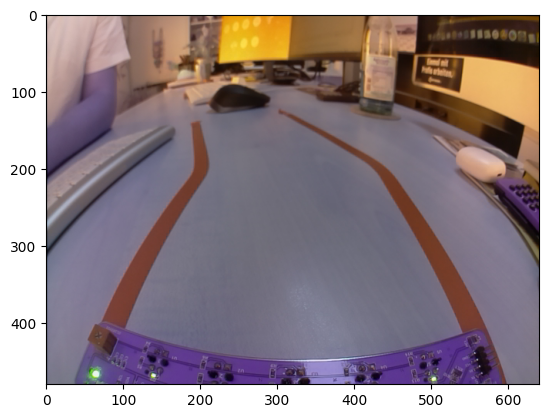

In [3]:
# Bild machen und Cam wieder freigeben
img = car.get_frame()
car.release()

# Bild speichern
cv.imwrite('strasse.jpg',img)

# Bild anzeigen
plt.imshow(img) # zeigt Bild in BGR-Farbe an!
print(img.shape)

(480, 640, 3)


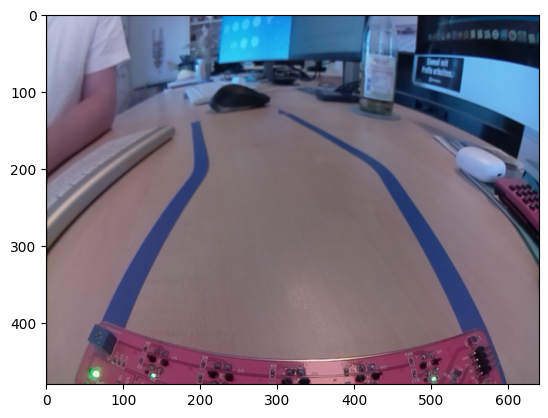

In [4]:
# Umwandeln in RGB
img_RGB = cv.cvtColor(img,cv.COLOR_BGR2RGB) 

plt.imshow(img_RGB)
print(img_RGB.shape)

(265, 525, 3)


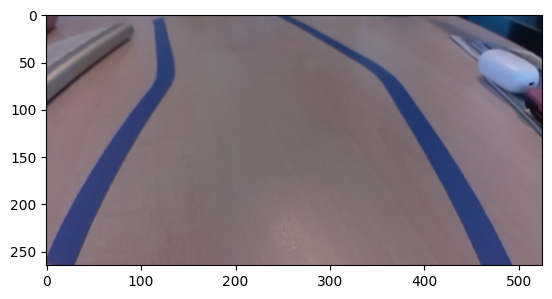

In [5]:
# Bildausschnitt erzeugen

img_cut = img_RGB[135:400,75:600].copy()         #Legt eine Kopie an und schneidet das bild aus
plt.imshow(img_cut)
print(img_cut.shape)

(265, 525, 3)


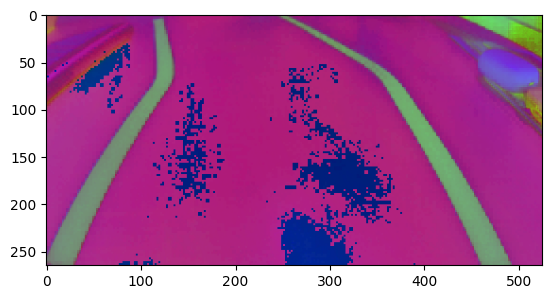

In [6]:
# Bild in HSV-Raum umwandeln
img_cut_HSV = cv.cvtColor(img_cut,cv.COLOR_RGB2HSV)

plt.imshow(img_cut_HSV)
print(img_cut_HSV.shape)

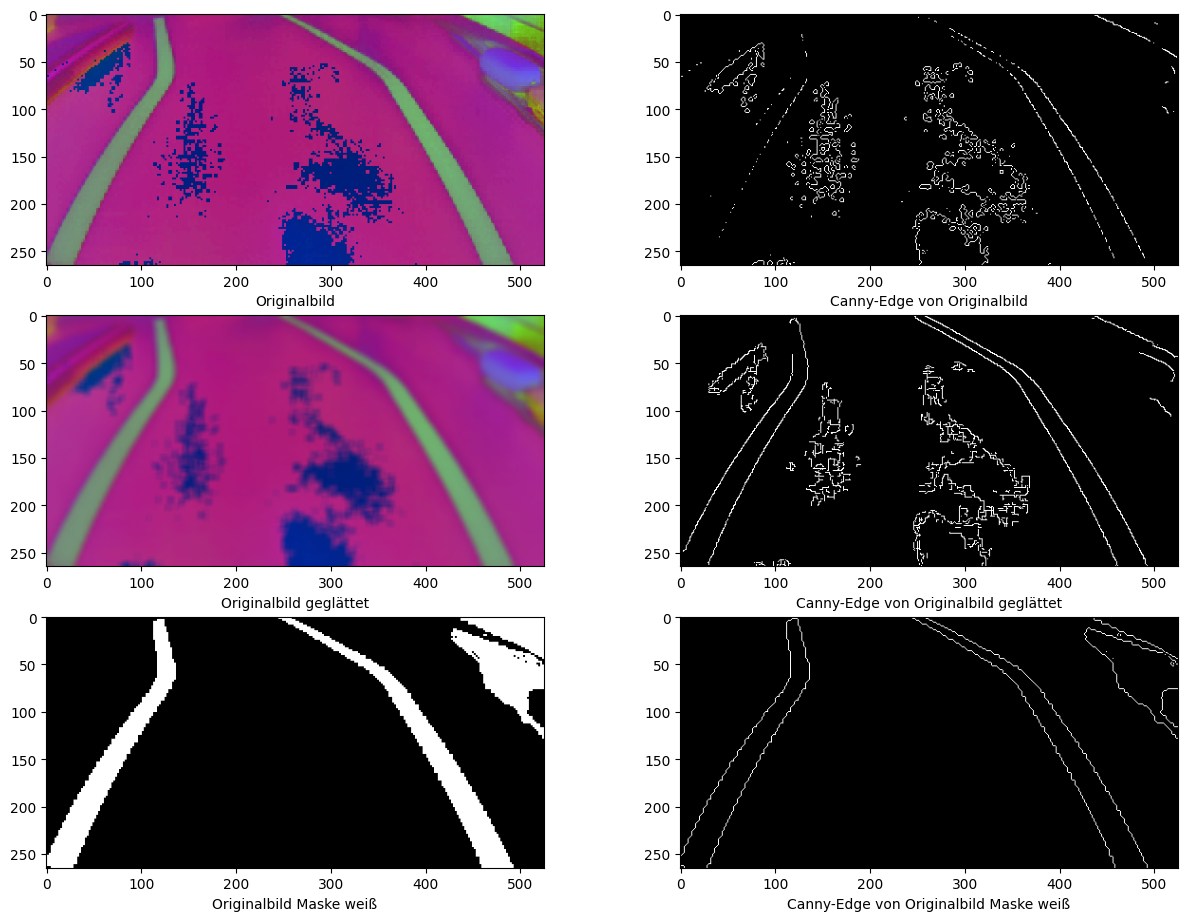

In [7]:
image = img_cut_HSV

image_blur= cv.blur(image,(8,8))

lower = np.array([95, 0, 0])
upper = np.array([125, 255, 255])
image_mask = cv.inRange(image, lower, upper)

plt.figure(figsize=(15,15))
plt.subplot(421)
plt.xlabel('Originalbild')
plt.imshow(image)

plt.subplot(422)
plt.xlabel('Canny-Edge von Originalbild')
plt.imshow(cv.Canny(image,440,450),cmap='gray')

plt.subplot(423)
plt.xlabel('Originalbild geglättet')
plt.imshow(image_blur,cmap='gray')

plt.subplot(424)
plt.xlabel('Canny-Edge von Originalbild geglättet')
plt.imshow(cv.Canny(image_blur,100,150),cmap='gray')

plt.subplot(425)
plt.xlabel('Originalbild Maske weiß')
plt.imshow(image_mask,cmap='gray')

plt.subplot(426)
image_edges = cv.Canny(image_mask,440,450)
plt.xlabel('Canny-Edge von Originalbild Maske weiß')
plt.imshow(image_edges,cmap='gray')

In [8]:
# Klassische Hough-Transformation
image_mask = cv.inRange(image, lower, upper)

rho = 1  # distance precision in pixel, i.e. 1 pixel
angle = np.pi / 180  # angular precision in radian, i.e. 1 degree
min_threshold = 180  # minimal of votes, Je geringer Min_threshold, dest mehr Geraden werden erkannt. 

parameter_mask = cv.HoughLines(image_mask, rho, angle, min_threshold)

print(parameter_mask.shape)     # am besten hier so wenig pixel wie möglich geändert wird dies über min_threshold
parameter_mask[:2]

(61, 1, 2)


array([[[-267.       ,    2.5830872]],

       [[-250.       ,    2.5307274]]], dtype=float32)

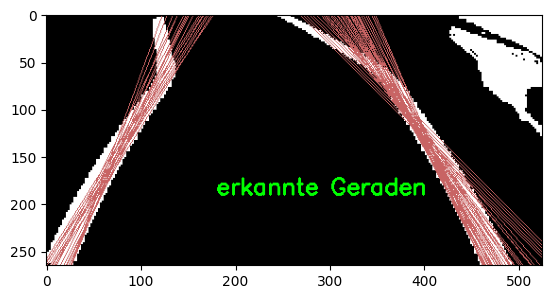

In [9]:
def draw_lines(parameter_mask,img):

    img2 = img.copy()
    img2 = cv.cvtColor(img2, cv.COLOR_GRAY2RGB)
    for line in parameter_mask:
        rho,theta = line[0]
        try:
            a = -np.cos(theta)/np.sin(theta) # Anstieg der Gerade
            b = rho/np.sin(theta)            # Absolutglied/Intercept/Schnittpunkt mit der y-Achse
            x1 = 0
            y1 = int(b)
            x2 = 1000
            y2 = int(a*1000+b)
        except:
            #print(f'Fehler{a,b}')
            pass
        #print(x1,x2,y1,y2)
        img2=cv.line(img2,(x1,y1),(x2,y2),(200,100,100),1) # adds a line to an image
        cv.putText(img2, 
            text = 'erkannte Geraden',
            org=(180,190), # Position
            fontFace= cv.FONT_HERSHEY_SIMPLEX,
            fontScale = .8, # Font size
            color = (0,255,0), # Color in rgb
            thickness = 2)
    return img2

imageresult =  draw_lines(parameter_mask, image_mask)  
plt.imshow(imageresult)  

In [10]:
# Probabilistische Hough-Transformation

image_mask = cv.inRange(image, lower, upper)
image_edges = cv.Canny(image_mask,200,400)
rho = 1              # distance precision in pixel, i.e. 1 pixel
angle = np.pi / 180  # angular precision in radian, i.e. 1 degree
min_threshold = 90   # in etwas Anzal der Punkt auf der Geraden. Je geringer Min_threshold, desto mehr Geraden werden erkannt.
minLineLength = 8    # Minimale Linienlänge
maxLineGap = 4       # Maximale Anzahl von Lücken in der Linie

line_segments = cv.HoughLinesP(image_mask, rho, angle, min_threshold, np.array([]), minLineLength=minLineLength, maxLineGap=maxLineGap)
print(line_segments.shape)
# Elemente stellen Punkte des Liniensegmentes dar (x1,y1,x2,y2)
line_segments[:2]

(94, 1, 4)


array([[[353,  53, 475, 264]],

       [[  0, 259, 134,  45]]], dtype=int32)

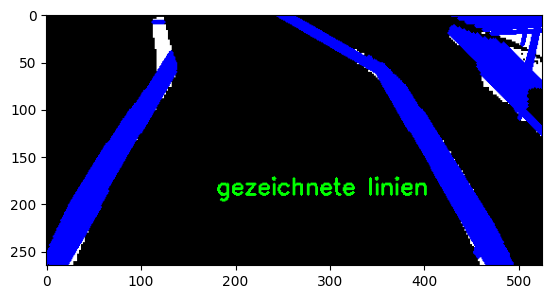

In [11]:
def draw_line_segments(line_segments,img):
    img2 = img.copy()
    img2 = cv.cvtColor(img2, cv.COLOR_GRAY2RGB)
    for line in line_segments:
        x1,y1,x2,y2 = line[0]
        cv.line(img2,(x1,y1),(x2,y2),(0,0,255),3)

    cv.putText(img2, 
            text = 'gezeichnete linien',
            org=(180,190), # Position
            fontFace= cv.FONT_HERSHEY_SIMPLEX,
            fontScale = .8, # Font size
            color = (0,255,0), # Color in rgb
            thickness = 2)

    return img2

image_result1 = draw_line_segments(line_segments,image_mask)

plt.imshow(image_result1)